In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.applications as app
import keras.layers as kl
import seaborn as sns
import matplotlib.patheffects as PathEffects
import cv2
import os
from keras.models import Model, Sequential
from keras.optimizers import Adagrad
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from time import time
from sklearn.manifold import TSNE
from mpl_toolkits import mplot3d
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
mnist = tf.keras.datasets.mnist

In [3]:
(x_train, y_train_),(x_test, y_test_) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_movie = x_train[:500]
y_movie = y_train_[:500]

x_train = np.reshape(x_train, (60000, 28, 28, 1))
x_test  = np.reshape(x_test, (10000, 28, 28, 1))

In [4]:
def triplet_generation(x, y, sample = 500):
    data = [[] for _ in range(10)]
    triplets = []
    for pair in zip(x, y):
        data[pair[1]].append(pair[0])
    for number in range(10):
        for _ in range(sample):
            negative = list(range(10))
            negative.pop(number)
            negative = random.choice(negative)
            triplet = ([random.choice(data[number]), 
                       random.choice(data[number]), 
                       random.choice(data[negative])], 
                       number)
            triplets.append(triplet)
    return np.array(triplets)

In [5]:
def triplet_loss(y_true, y_pred, m = 0.1):
    length = int((y_pred[0].shape[-1]))
    
    
    anchor_vec   = y_pred[:, :int(length/3)]
    positive_vec = y_pred[:, int(length/3):int(length/1.5)]
    negative_vec = y_pred[:, int(length/1.5):length]
    
    bad  = K.sum(K.square(anchor_vec - positive_vec), axis = 1)
    good = K.sum(K.square(anchor_vec - negative_vec), axis = 1)

    loss = bad - good + m
    return K.maximum(loss, 0.)

In [6]:
def new_triplet_loss(y_true, y_pred, m = 3, beta = 3, epsilon = 1e-8):
    length = int((y_pred[0].shape[-1]))
    
    anchor_vec   = y_pred[:, :int(length/3)]
    positive_vec = y_pred[:, int(length/3):int(length/1.5)]
    negative_vec = y_pred[:, int(length/1.5):length]
    
    bad  = K.sum(K.square(anchor_vec - positive_vec), axis = 1)
    good = K.sum(K.square(anchor_vec - negative_vec), axis = 1)
    
    bad  = -tf.log(-tf.divide((bad), beta) + 1 + epsilon)
    good = -tf.log(-tf.divide((m - good), beta) + 1 + epsilon)
    
    loss = bad + good
    return loss


In [7]:
anchor_input   = kl.Input((28, 28, 1), name = 'anchor_input')
positive_input = kl.Input((28, 28, 1), name = 'positive_input')
negative_input = kl.Input((28, 28, 1), name = 'negative_input')

In [8]:
def base_model():
    model = Sequential()
    model.add(kl.Conv2D(32, 2, input_shape=(28, 28,1), activation='relu', padding='valid'))
    model.add(kl.MaxPooling2D())
    model.add(kl.Conv2D(64, 2, activation='relu', padding='valid'))
    model.add(kl.MaxPooling2D())
    model.add(kl.Flatten())
    model.add(kl.Dense(256, activation = 'relu'))
    model.add(kl.BatchNormalization())
    model.add(kl.Dropout(0.5))
    model.add(kl.Dense(3))
    #model.add(kl.Lambda(lambda t: K.l2_normalize(1000*t, axis=1)))
    
    return model

In [9]:
shared_network = base_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
anchor   = shared_network(anchor_input)
positive = shared_network(positive_input)
negative = shared_network(negative_input)

merged = kl.concatenate([anchor, positive, negative], axis = 1)

model = Model(inputs = [anchor_input, positive_input, negative_input], outputs = merged)

In [11]:
opt = Adagrad()

In [12]:
model.compile(optimizer = opt, loss = triplet_loss)

In [13]:
data_train = triplet_generation(x_train, y_train_, 3500)

In [14]:
data_test  = triplet_generation(x_test, y_test_, 200)

In [15]:
anchor_train   = []
positive_train = []
negative_train = []
y_train        = []
np.random.shuffle(data_train)
for data in data_train:
    anchor_train.append(data[0][0])
    positive_train.append(data[0][1])
    negative_train.append(data[0][2])
    y_train.append(data[1])

In [16]:
anchor_test   = []
positive_test = []
negative_test = []
y_test        = []
np.random.shuffle(data_test)
for data in data_test:
    anchor_test.append(data[0][0])
    positive_test.append(data[0][1])
    negative_test.append(data[0][2])
    y_test.append(data[1])

In [17]:
class LiveAction(Callback):
    def on_train_begin(self, logs={}):
        self.counter = 0
        
    def on_batch_end(self, batch, logs={}):
        self.counter += 1
        if not self.counter % 70:
            x = self.model.predict(3*[x_movie[:500].reshape(-1,28,28,1)])[:, :3]
            palette = np.array(sns.color_palette("hls", 10))
            fig = plt.figure()
            ax  = plt.axes(projection="3d")
            ax.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                                c=palette[np.array(y_movie[:500]).astype(np.int)]);
            ax.set_xlim(-2,2)
            ax.set_ylim(-2,2)
            ax.set_zlim(-2,2)
            fig.savefig('./movie/{}.png'.format(self.counter//70))
            plt.close(fig)

In [18]:
live_action = LiveAction()

In [ ]:
model.fit([anchor_train, positive_train, negative_train],
          y               = y_train,
          validation_data = ([anchor_test,positive_test,negative_test], y_test), 
          batch_size      = 128, 
          epochs          = 20, 
          callbacks       = [live_action]
          ) 

Instructions for updating:
Use tf.cast instead.
Train on 35000 samples, validate on 2000 samples
Epoch 1/20
 1536/35000 [>.............................] - ETA: 5:27 - loss: 3.1658

In [ ]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
coordOfText            = (10,20)
fontScale              = 0.5
fontColor              = (0,0,0)
lineType               = 2
frame_name             = os.listdir('./movie/')
number_frame           = max([int(name[:-4]) for name in frame_name if name.endswith('.png')])
image_array            = []


In [56]:
for i in range(1, number_frame):
    image = cv2.imread('./movie/{}.png'.format(i))
    image = cv2.putText(image, 'Batch {}'.format(i*70), coordOfText, font, fontScale, fontColor, lineType)
    image_array.append(image)
    
size = (image_array[0].shape[1], image_array[0].shape[0])



In [57]:
fourcc = cv2.VideoWriter_fourcc(*'MP42')
video = cv2.VideoWriter('./noise.avi', fourcc, float(10), size)
for frame in image_array:
    video.write(frame)

In [58]:
video.release()

In [51]:
model.save_weights("model{}.h5".format(time()))

In [20]:
trained_model = Model(inputs = anchor_input, outputs = anchor)

In [38]:
tsne = TSNE(3)
indices = np.arange(10000)
np.random.shuffle(indices)
indices = indices[:600]
X_train_trm = trained_model.predict(x_train[indices].reshape(-1,28,28,1))
X_test_trm = trained_model.predict(x_test[indices].reshape(-1,28,28,1))
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)

In [42]:
x = train_tsne_embeds

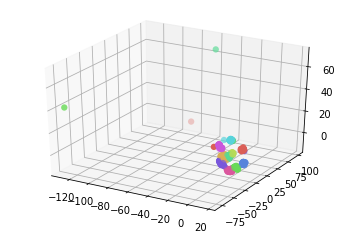

In [47]:
fig = plt.figure()
ax  = plt.axes(projection="3d")
ax.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                    c=palette[np.array(y_train[indices]).astype(np.int)]);
ax.set_xlim(-12,12)
ax.set_ylim(-12,12)
ax.set_zlim(-12,12)
fig.savefig('')

In [28]:
class LiveAction(Callback):
    def on_train_begin(self, logs={}):
        self.counter = 0
        
    def on_batch_end(self, batch, logs={}):
        self.counter += 1
        if not self.counter % 70:
            x = self.model.predict(3*[x_movie.reshape(-1,28,28,1)])[:, :4]
            tsne = TSNE(3)
            x = tsne.fit_transform(x)
            palette = np.array(sns.color_palette("hls", 10))
            fig = plt.figure(figsize = (8, 8))
            ax  = plt.axes(projection="3d")
            ax.scatter3D(x[:,0], x[:,1], x[:,2], lw = 0, s = 40, c = palette[np.array(y_movie).astype(np.int)]);
            ax.set_xlim(-100,100)
            ax.set_ylim(-100,100)
            ax.set_zlim(-100,100)
            fig.savefig('./movie/{}.png'.format(self.counter//70))
            plt.close(fig)

SyntaxError: invalid syntax (<ipython-input-33-4839f42c26c8>, line 1)

In [25]:
y_train[2]

9

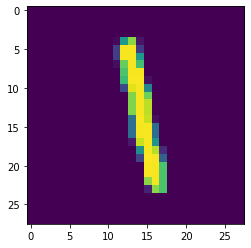

In [39]:
plt.imshow(np.reshape(negative_test[10], (28, 28)))

In [122]:
random.shuffle(test)

In [123]:
test

[3, 5, 2, 4, 6, 1]

In [25]:
train_gen = data_gen.flow(x_train, y_train, shuffle = True)
test_gen  = data_gen.flow(x_test, y_test)

NameError: name 'data_gen' is not defined

In [30]:
test = triplet_generation(x_train, y_train)

In [32]:
plt.imshow(np.reshape(255*anchor_test[1500], (28, 28)))

ValueError: cannot reshape array of size 1 into shape (28,28)

In [21]:
df = list(range(10))

In [44]:
len(test)

5000

In [25]:
x_train.shape

(60000, 28, 28, 1)